In [41]:
import requests
from requests.exceptions import HTTPError

import pandas as pd
from decimal import Decimal
from pandas.io.json import json_normalize
import json

import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt 



#Variables/Params
api_key = '46583da07984f6f5e5acc0442fad24656e164280da7811e9aefa8bcfc9d1' #defi pulse
request = '/defipulse/api/getLendingHistory' #getlending history
#add support for BulkAPIMonitor
requesturl = 'https://data-api.defipulse.com/api/v1' + request +'?api-key=' + api_key + '&period=1y'


In [42]:
#get json query
try:
    response = requests.get(requesturl)
    response.raise_for_status()
    # access JSOn content
    api_output = response.json()
    #print("Entire JSON response")
    #print(api_output[0]) #validate response from API

except HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')
except Exception as err:
    print(f'Other error occurred: {err}')


In [43]:
#extract lending data and dump into a dataframe
df = pd.DataFrame.from_dict(api_output)
df1 = df[['timestamp','lend_rates']]
timestamps = df1['timestamp']
timestamps = pd.to_datetime(timestamps,unit='s').dt.date
data = pd.json_normalize(df1['lend_rates'])
lendingdata = pd.merge(timestamps, data, left_index=True, right_index=True)

In [44]:
lendingdata['datetime'] = pd.to_datetime(lendingdata['timestamp'])
lendingdata = lendingdata.set_index(['datetime']).drop(columns=['timestamp']).divide(365).replace(np.inf, 0).replace(np.nan, 0) 
#Normalise to 365 days and replace null or nan with 0 values.
#Return lending data

In [45]:
lendingdata

,maker,compound,aave,dydx,c.r.e.a.m.-finance,definer
datetime,,,,,,
2021-08-26,0.000027,0.006533,0.006127,0.011176,0.012998,0.008424
2021-08-25,0.000027,0.006357,0.006434,0.009082,0.013389,0.008149
2021-08-24,0.000027,0.007266,0.005222,0.010912,0.017130,0.011809
2021-08-23,0.000027,0.006198,0.009735,0.009207,0.016258,0.008126
2021-08-22,0.000027,0.006127,0.009683,0.008773,0.015855,0.007937
...,...,...,...,...,...,...
2020-08-31,0.000000,0.007916,0.000000,0.006663,0.015252,0.000000
2020-08-30,0.000000,0.007892,0.000000,0.006315,0.000000,0.000000
2020-08-29,0.000000,0.007927,0.000000,0.005983,0.000000,0.000000


In [46]:
import pypfopt

riskmatrix = pypfopt.risk_models.risk_matrix(lendingdata, method='sample_cov',)

riskmatrix




,maker,compound,aave,dydx,c.r.e.a.m.-finance,definer
maker,1.384615,0.106284,0.085764,0.933302,-0.157788,-0.101966
compound,0.106284,5.353325,1.436764,1.615108,2.032856,6.228003
aave,0.085764,1.436764,11.784069,0.725309,-1.380673,0.954474
dydx,0.933302,1.615108,0.725309,36.183855,1.702612,1.552464
c.r.e.a.m.-finance,-0.157788,2.032856,-1.380673,1.702612,44.269983,1.196029
definer,-0.101966,6.228003,0.954474,1.552464,1.196029,21.122765


In [54]:
from pypfopt import expected_returns, EfficientSemivariance, plotting, risk_models

df = lendingdata # your dataframe of prices
mu = expected_returns.mean_historical_return(df).replace(np.inf, 0).replace(np.nan, 0) 
historical_returns = expected_returns.returns_from_prices(df).replace(np.inf, 0).replace(np.nan, 0) 
mu.head()

maker                -1.000000
compound              0.126063
aave                 -1.000000
dydx                  0.014081
c.r.e.a.m.-finance    0.000000
dtype: float64

In [55]:

es = EfficientSemivariance(mu, historical_returns)
es.efficient_return(0.10)

# We can use the same helper methods as before
weights = es.clean_weights()
print(weights)
es.portfolio_performance(verbose=True)

OrderedDict([('maker', 0.00256), ('compound', 0.80123), ('aave', 0.0), ('dydx', 0.11005), ('c.r.e.a.m.-finance', 0.08616), ('definer', 0.0)])
Expected annual return: 10.0%
Annual semi-deviation: 115.3%
Sortino Ratio: 0.07


(0.09999999999999998, 1.1528393089482643, 0.06939388636303875)

In [56]:

S = risk_models.sample_cov(df)
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))

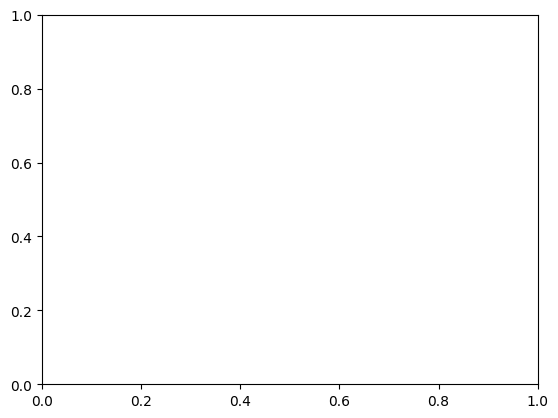

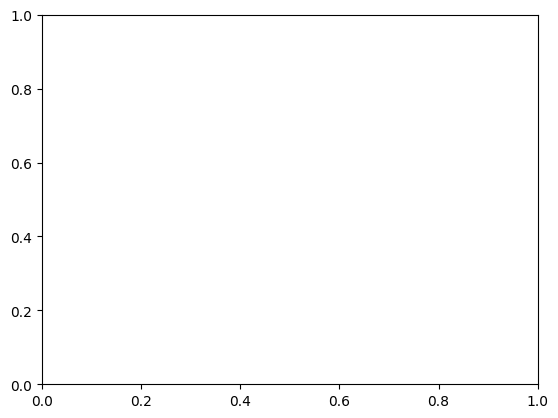

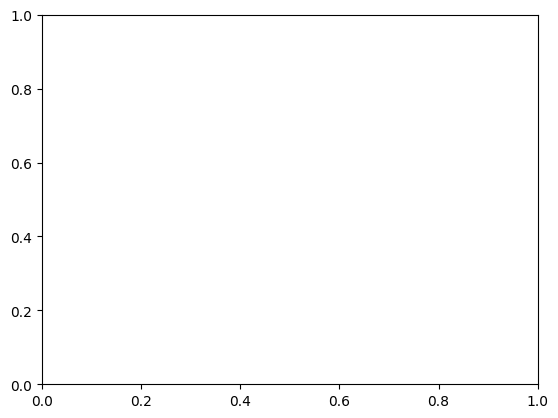

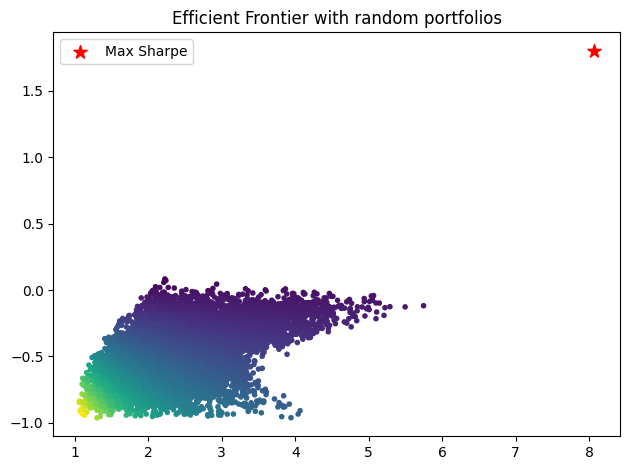

In [58]:
fig, ax = plt.subplots()

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()